In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import typing as ty

from decimal import Decimal

from mortgage_sim import display_payment_plan
from mortgage_sim.Finances import Finances
from mortgage_sim.FinancialDate import FinancialDate
from mortgage_sim.FinancialDelta import FinancialDelta
from mortgage_sim.Mortgage import Mortgage
from mortgage_sim.MinRestDurationPaybackStrategy import MinRestDurationPaybackStrategy
from mortgage_sim.RepaymentParameterSet import RepaymentParameterSet
from mortgage_sim.PaymentPlan import PaymentPlan
from mortgage_sim.TemporalValue import TemporalValue
from mortgage_sim.Wallet import Wallet
from mortgage_sim.types import Percentage

In [2]:
start_date = FinancialDate(year=2024, month=1)  # Define the date on which the mortgage repayment will start.

In [3]:
# The finances contain
finances = Finances(0) \
    .add_income('Income: A', start_date, 4_000, recurrence=FinancialDelta(months=1)) \
    .add_income('Income: A', FinancialDate(year=2024, month=5), 5_000, FinancialDelta(months=1)) \
    .add_income('Extra Income: A Vacation', start_date + FinancialDelta(months=5), 3_000, FinancialDelta(months=12)) \
    .add_income('Extra Income: A Christmas', FinancialDate(year=2024, month=11), 4_000, FinancialDelta(months=12)) \
    .add_income('Extra Income: A Annual Bonus', FinancialDate(year=2024, month=12), 500, FinancialDelta(months=12)) \
    .add_income('Income: B', start_date, 715, FinancialDelta(months=1)) \
    .remove_income('Income: B', FinancialDate(year=2027, month=9)) \
    .add_expense('Food', start_date, 800, FinancialDelta(months=1)) \
    .add_expense('Mobility', start_date, 300, FinancialDelta(months=1)) \
    .add_expense('Health', start_date, 75, FinancialDelta(months=1)) \
    .add_expense('Consumption', start_date, 140, FinancialDelta(months=1)) \
    .add_expense('Clothing', start_date, 135, FinancialDelta(months=1)) \
    .add_expense('Childcare', FinancialDate(year=2024, month=11), 200, FinancialDelta(months=1)) \
    .remove_expense('Childcare', FinancialDate(year=2029, month=7)) \
    .add_expense('Cash', start_date, 80, FinancialDelta(months=1)) \
    .add_expense('Ancillary Expenses', start_date, 50, FinancialDelta(months=1)) \
    .add_expense('Heating', start_date + FinancialDelta(months=6), 150, FinancialDelta(months=1)) \
    .add_expense('Helath Insurance', start_date, 245, FinancialDelta(months=1)) \
    .add_expense('Accident Insurance', start_date, 25, FinancialDelta(months=1)) \
    .add_expense('Domestic Policy', start_date, 100, FinancialDelta(months=12)) \
    .add_expense('Income Protection', start_date, 54, FinancialDelta(months=1)) \
    .add_expense('Legal Costs Insurance', start_date, 100, FinancialDelta(months=12)) \
    .add_expense('Term Life Insurance', start_date, 25, FinancialDelta(months=1)) \
    .add_expense('Building Insurance', start_date, 20, FinancialDelta(months=1)) \
    .add_expense('Pension Plan', start_date, 250, FinancialDelta(months=1))

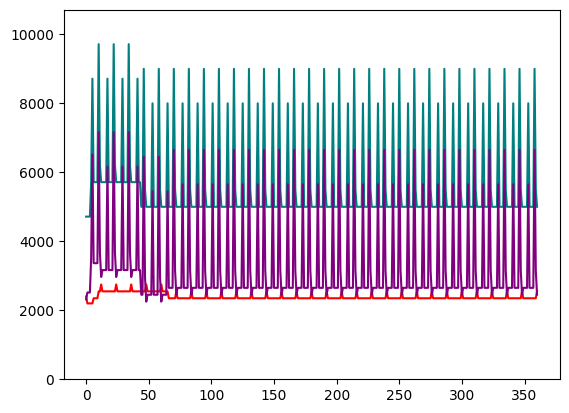

In [4]:
%matplotlib inline
fig = plt.figure()

indices = np.array(range(0, 30 * 12 + 1))
incomes = np.array([finances.get_effective_income_value(FinancialDate(year=2024, month=1) + FinancialDelta(months=m)) for m in indices])
expenses = np.array([finances.get_effective_expense_value(FinancialDate(year=2024, month=1) + FinancialDelta(months=m)) for m in indices])
balances = np.array([finances.get_effective_balance(FinancialDate(year=2024, month=1) + FinancialDelta(months=m)) for m in indices])

plt.ylim(min(min(incomes), min(expenses), 0), max(max(incomes), max(expenses)) + 1000)
plt.plot(indices, incomes, color='teal')
plt.plot(indices, expenses, color='red')
plt.plot(indices, balances, color='purple')
plt.show()


In [5]:
def create_follow_up(mortgage: Mortgage, payment_plan: PaymentPlan, wallet: Wallet, new_interest_rate: Percentage, min_payback_rate: Percentage) -> ty.Optional[Mortgage]:
    name = f'{mortgage.name} Follow'
    
    param_set = mortgage.repayment_parameter_set
    new_start_date = mortgage.valid_until
    surplus = min(wallet.get_surplus(new_start_date), mortgage.current_amount)
    
    payment_plan.record(f'{mortgage.name} Unscheduled', surplus, Decimal(0))
    current_amount = mortgage.current_amount - surplus
    wallet -= surplus
    
    if current_amount <= Decimal(0):
        return None
    
    current_monthly_payment = mortgage.monthly_payment_amount
    new_monthly_interest_value = round(new_interest_rate.decimal_fraction * current_amount / Decimal(12), 2)
    new_payback_value = max(0, current_monthly_payment - new_monthly_interest_value) * Decimal(12)
    new_payback_rate = max(min_payback_rate, Percentage(new_payback_value / current_amount * 100))
    
    new_min_value = param_set.min_value(mortgage.initial_amount)
    new_max_value = param_set.max_value(mortgage.initial_amount)
    new_payments_per_year = param_set.payments_per_year
    new_param_set = RepaymentParameterSet(new_min_value, new_max_value, new_payments_per_year)
    
    return Mortgage(name, current_amount, new_interest_rate, new_payback_rate, new_start_date, None, new_param_set)

In [6]:
def get_wallet() -> Wallet:
    return Wallet(5000) \
        .add_saving_policy('Reserve', start_date, 10_000) \
        .add_saving_policy('Reserve+', start_date, 2_500, FinancialDelta(years=1)) 

In [7]:
def get_mortgages(mortgage_start_date: FinancialDate, new_interest_rate: Percentage, wallet: Wallet) -> ty.List[Mortgage]:    
    # Mortgages
    short_repayment_parameter_set = RepaymentParameterSet(1_000, Percentage(5), 12)
    short_mortgage = Mortgage('Short', 300_000, Percentage(3.73), Percentage(2), mortgage_start_date, mortgage_start_date + FinancialDelta(years=10), short_repayment_parameter_set) \
        .register_follow_up_creator(lambda m, p: create_follow_up(m, p, wallet, new_interest_rate, Percentage(0.5)))

    long_repayment_parameter_set = RepaymentParameterSet(1_000, Percentage(5), 12)
    long_mortgage = Mortgage('Long', 100_000, Percentage(4.17), Percentage(0), mortgage_start_date, mortgage_start_date + FinancialDelta(years=14), long_repayment_parameter_set) \
        .alter_payback_rate(FinancialDate(year=2024, month=7), Percentage(2)) \
        .register_follow_up_creator(lambda m, p: create_follow_up(m, p, wallet, new_interest_rate, Percentage(0.5)))
        
    return [short_mortgage, long_mortgage]

In [8]:
def get_payment_plan(new_interest_rate: Percentage, strategy_class: ty.Type) -> pd.DataFrame:
    mortgage_start_date = FinancialDate(year=2024, month=2)
    wallet = get_wallet()
    mortgages = get_mortgages(mortgage_start_date, new_interest_rate, wallet)
    return strategy_class(mortgages).calculate_payment_plan(mortgage_start_date, finances, wallet)

In [9]:
def get_reference_payment_plan(new_interest_rate: Percentage, strategy_class: ty.Type) -> pd.DataFrame:
    mortgage_start_date = FinancialDate(year=2024, month=2)
    wallet = get_wallet()
    mortgages = get_mortgages(mortgage_start_date, new_interest_rate, wallet)
    for mortgage in mortgages:
        mortgage.alter_repayment_parameter_set(mortgage_start_date, RepaymentParameterSet(0, 0, 0))
    return strategy_class(mortgages).calculate_payment_plan(mortgage_start_date, finances, wallet)

In [10]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


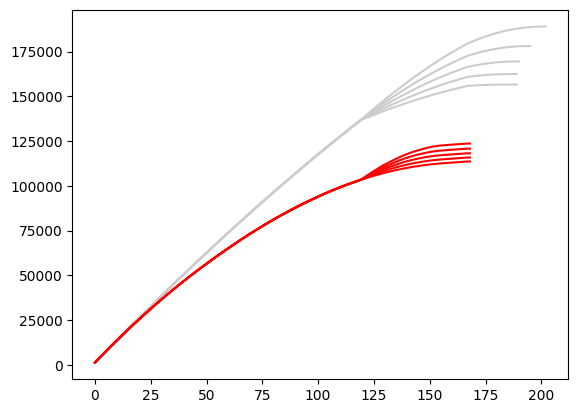

In [11]:
%matplotlib inline
fig = plt.figure()

follow_up_interest_rates = np.linspace(3.73, 12.5, num=5)

def plot_strategy(payment_plans, **kwargs):
    longest_payment_plan = max(payment_plans, key=lambda x: len(x))

    scenarios = list()
    for payment_plan in payment_plans:
        scenario = np.empty(len(longest_payment_plan))
        scenario[:] = np.nan
        scenario[0:len(payment_plan)] = np.nancumsum(payment_plan['Interest Sum'], axis=0)
        scenarios.append(scenario)

    for scenario in scenarios:
        plt.plot(longest_payment_plan['Month'], scenario, **kwargs)

strategy = MinRestDurationPaybackStrategy
ref_payment_plan_collection = [get_reference_payment_plan(Percentage(rate), strategy) for rate in follow_up_interest_rates]
payment_plan_collection = [get_payment_plan(Percentage(rate), strategy) for rate in follow_up_interest_rates]
plot_strategy(ref_payment_plan_collection, color=f'#CCCCCC')
plot_strategy(payment_plan_collection, color=f'#FF0000')


plt.show()


In [12]:
payment_plan_collection = [get_payment_plan(Percentage(rate), MinRestDurationPaybackStrategy) for rate in follow_up_interest_rates]
reference_payment_plan_collection = [get_reference_payment_plan(Percentage(rate), MinRestDurationPaybackStrategy) for rate in follow_up_interest_rates]

In [13]:
display_payment_plan(payment_plan_collection[0], reference_payment_plan_collection[0])